# Regression Tree

In [10]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import graphviz
import matplotlib.pyplot as plt

## Load the data

In [11]:
regression_label = 'habitat_richness'
folder = "../Dataset"
file = "/bulgaria_out_closest_point_mean_handle_custom_set.csv"

df = pd.read_csv(folder + file, index_col=['longitude', 'latitude'])
#df = df[df[regression_label] > 0]
y = df[regression_label].values
X = df.drop(columns=[regression_label]).values #returns a numpy array

df.head()

habitat_richness        NDVI  ALBH-AL-BH-VI  \
longitude latitude                                                
22.00     41.00             0.271709  190.916667          585.5   
          41.02             0.238445  177.375000          481.5   
          41.03             0.248366  234.583333          503.0   
22.01     41.00             0.344144  195.777778          715.0   
          41.04             0.248366  246.444444          406.0   

                    ALBH-AL-BH-BB  ALBH-AL-BH-NI  ALDH-AL-DH-VI  \
longitude latitude                                                
22.00     41.00            2060.0         3108.0          523.0   
          41.02            2014.5         3102.0          538.0   
          41.03            2057.5         3157.5          334.5   
22.01     41.00            2166.0         3196.0          672.0   
          41.04            1935.0         3007.0          305.0   

                    ALDH-AL-DH-BB  ALDH-AL-DH-NI  DMP300-RT5-DMP  \
longitude latitude                                                 
22.00     41.00            1738.0         2614.0    10954.250000   
          41.02            1745.0         2616.0     8152.187500   
          41.03            1645.5         2580.0    13376.166667   
22.01     41.00            1812.0         2634.0    10711.666667   
          41.04            1775.0         2818.0    13044.777778   

                    FAPAR300-FAPAR  ...         ssr        str        sp  \
longitude latitude                  ...                                    
22.00     41.00         155.666667  ...  11974753.0 -5358995.0  95331.58   
          41.02         112.437500  ...  11974753.0 -5358995.0  95331.58   
          41.03         130.500000  ...  11974753.0 -5358995.0  95331.58   
22.01     41.00         148.555556  ...  11974753.0 -5358995.0  95331.58   
          41.04         124.666667  ...  11974753.0 -5358995.0  95331.58   

                          ssrd        strd        tp     swvl1     swvl2  \
longitude latitude                                                         
22.00     41.00     14479887.0  26990748.0  0.002715  0.332401  0.332663   
          41.02     14479887.0  26990748.0  0.002715  0.332401  0.332663   
          41.03     14479887.0  26990748.0  0.002715  0.332401  0.332663   
22.01     41.00     14479887.0  26990748.0  0.002715  0.332401  0.332663   
          41.04     14479887.0  26990748.0  0.002715  0.332401  0.332663   

                       swvl3     swvl4  
longitude latitude                      
22.00     41.00     0.313627  0.308605  
          41.02     0.313627  0.308605  
          41.03     0.313627  0.308605  
22.01     41.00     0.313627  0.308605  
          41.04     0.313627  0.308605  

[5 rows x 47 columns]

The covariance matrix provides information about the correlation of the features

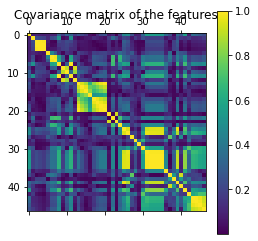

In [12]:
norm=(df-df.mean())/df.std()
covariance = norm.cov()
plt.matshow(np.abs(covariance))
plt.colorbar()
plt.title('Covariance matrix of the features')
plt.margins(0.05,0.5)

## Data preparation

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Normalize the data
X_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()


# Test values have to be normalized with the training mean and std
y_scaler.fit(y_train.reshape(-1, 1))
y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()
y = y_scaler.transform(y.reshape(-1, 1)).ravel()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
X = X_scaler.transform(X)

In [14]:
clfXtrain = RandomForestRegressor(n_estimators=100, max_depth=None)
clfXtrain = clfXtrain.fit(X_train,y_train)
print("Random Forest validation score: ", clfXtrain.score(X_test, y_test))

Random Forest validation score:  0.930662584518832


## Feature importances

The random forest model will identify the features which have been most useful to the prediction. Visualizing these features will help to understand which are the factors that mostly influence the biodiversity of the considered habitat

Feature ranking:
1. feature strd (0.475538)
2. feature ssrd (0.144723)
3. feature tp (0.057949)
4. feature lai_lv (0.041824)
5. feature slhf (0.031968)
6. feature ssr (0.029291)
7. feature skt (0.022188)
8. feature swvl4 (0.014553)
9. feature ALDH-AL-DH-VI (0.010415)
10. feature d2m (0.010299)
11. feature lai_hv (0.010087)
12. feature FCOVER300-FCOVER (0.007853)
13. feature TOCR-REF-NOR-BLUE (0.007405)
14. feature src (0.006681)
15. feature str (0.006526)
16. feature sp (0.006487)
17. feature fal (0.006332)
18. feature TOCR-REF-NOR-SWIR (0.006310)
19. feature TOCR-REF-NOR-NIR (0.006299)
20. feature TOCR-REF-NOR-RED (0.005593)
21. feature NDVI (0.005275)
22. feature LAI300-LAI (0.005192)
23. feature ALBH-AL-BH-NI (0.005116)
24. feature ALBH-AL-BH-VI (0.004926)
25. feature swvl2 (0.004712)
26. feature swvl1 (0.004653)
27. feature GDMP300-RT5-GDMP (0.004560)
28. feature SWI1km-SWI-100 (0.004533)
29. feature FAPAR300-FAPAR (0.004509)
30. feature ALDH-AL-DH-NI (0.004444)
31. feature DMP300-

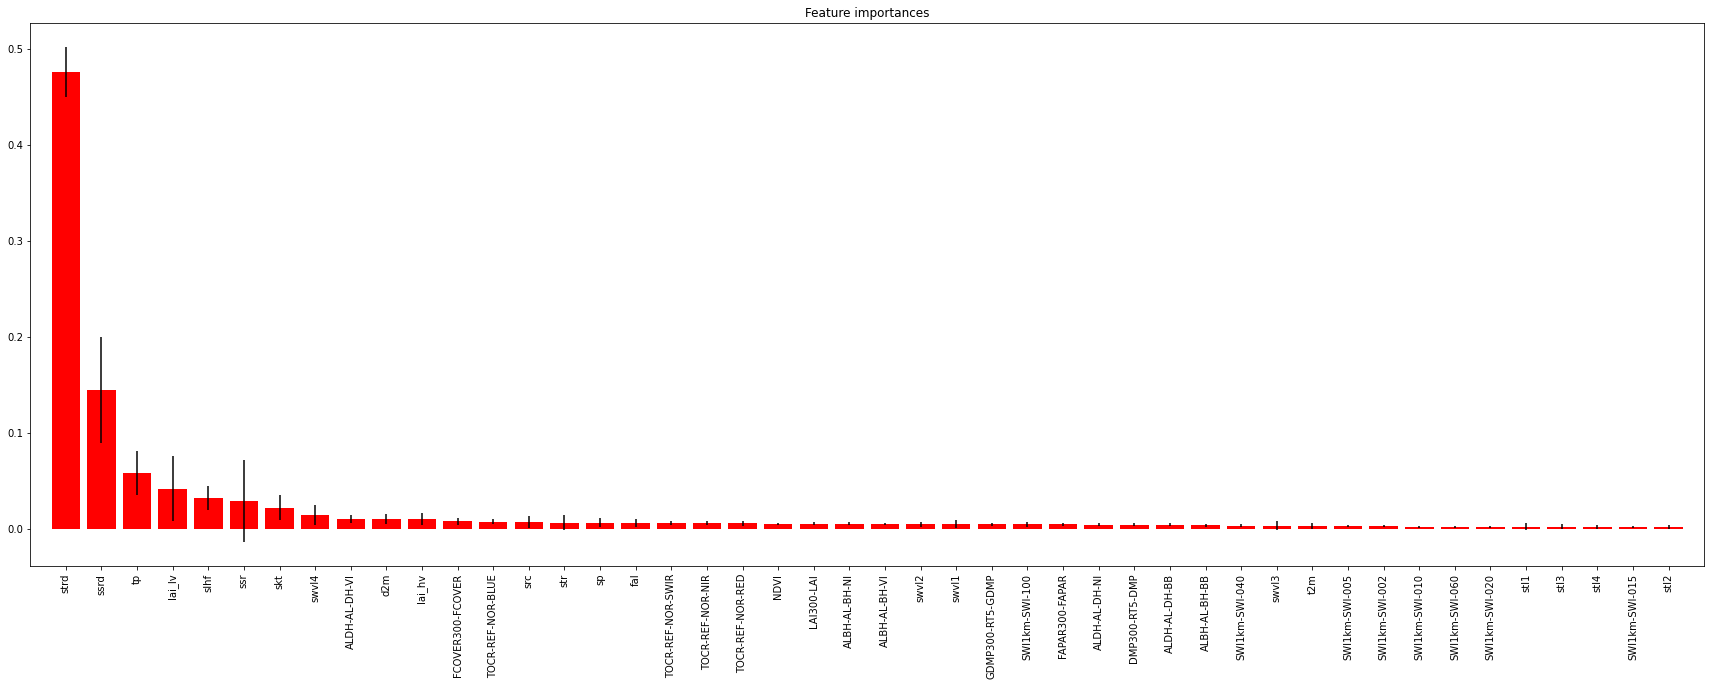

In [15]:
importances = clfXtrain.feature_importances_
std = np.std([tree.feature_importances_ for tree in clfXtrain.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

feat_names = list(df.drop(columns=[regression_label]).columns.values) 

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feat_names[indices[f]], importances[indices[f]]))

names = [feat_names[i] for i in indices]
# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(30, 10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [16]:
imp_index = np.argsort(importances)[::-1]
imp = np.sort(importances)[::-1]

num_feats = 10
print("The first", num_feats, "features contribute to the",  np.cumsum(imp)[num_feats], "of the result")
print("These features are:")
names[:num_feats]

The first 10 features contribute to the 0.848835206507521 of the result
These features are:


['strd',
 'ssrd',
 'tp',
 'lai_lv',
 'slhf',
 'ssr',
 'skt',
 'swvl4',
 'ALDH-AL-DH-VI',
 'd2m']

## Remove least important features

After determining the importance of each feature through random forest, removing the least important ones improves the performace of a single regression tree

In [17]:
# Select only the 30 most important features
num_feats = 10 # number of retained features
remove_f = names[:num_feats]

# Prepare the data
y = df[regression_label].values
# Select only the most important features in X
X = df.drop(columns=[regression_label])[remove_f].values #returns a numpy array
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Normalize the data
X_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
# Test values have to be normalized with the training mean and std
y_scaler.fit(y_train.reshape(-1, 1))
y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()
y = y_scaler.transform(y.reshape(-1, 1)).ravel()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
X = X_scaler.transform(X)
X_train.shape

(11566, 10)

### Train a decision tree with the remaining features

It is important to choose a good value for the max_depth of the tree, because trees too deep tend to overfit. So far the best result has been obtained with a max_depth of 7.

Regression Tree model score:  0.7676897984705673


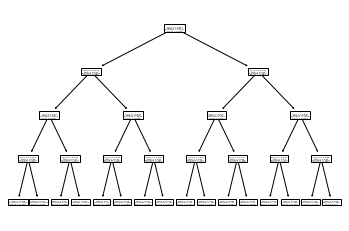

In [18]:
decision_tree = tree.DecisionTreeRegressor(max_depth=4)
decision_tree = decision_tree.fit(X_train,y_train)
print("Regression Tree model score: ", decision_tree.score(X_test, y_test))

plt.figure()
tree.plot_tree(decision_tree)
plt.show()

## Tree visualization

Once the graph has been exported to a .dot file, graphical renderings can be generated using, for example:
```
$ dot -Tpng tree.dot -o tree.png    (PNG format)
```

In [19]:
feat_names = list(df.drop(columns=[regression_label]).columns.values) 
dot_data = tree.export_graphviz(decision_tree,out_file='tree.dot',feature_names=remove_f, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)

### Dtreeviz visualization

Dtreeviz offers a great way to produce tree visualization with a lot of insight of how the mdoel takes decisions. 

In [20]:
from dtreeviz.trees import *
viz = dtreeviz(decision_tree,
               X_train,
               y_train,
               target_name='habitat_richness',
               feature_names=names)
viz.view()
viz.save('dtreeviz_visualization')

## Prediction Path

The following visualization shows how the tree chooses a path when obtaining the regression. This kind of plot could be useful in a real-case scenario, because if the model makes a warning prediction it would be useful to understand the features it considered.

In [10]:
X = X_train[np.random.randint(0, len(X_train)),:]  # random sample from training

viz = dtreeviz(decision_tree,
               X_train,
               y_train,
               target_name='habitat_richness',
               orientation ='LR',  # left-right orientation
               feature_names=names,
               X=X)  # need to give single observation for prediction

viz.view()

In [ ]:
viz = dtreeviz(decision_tree,
        X_train,
        y_train,
        target_name='habitat_richness', 
        orientation ='TD',  # top-down orientation
        feature_names=names,
        X=X, # need to give single observation for prediction
        show_just_path=True)

viz.view()

## Testing Random Forest with less features

In [197]:
clfXtrain = RandomForestRegressor(n_estimators=100, max_depth=None)
clfXtrain = clfXtrain.fit(X_train,y_train)
print("Random Forest validation score: ", clfXtrain.score(X_test, y_test))

Random Forest validation score:  0.7526573971655095


## Working with all the data

In [225]:
import glob

folder = "../Dataset"
regression_label = 'habitat_richness'
test_size = 0.2
swi_labels = ['SWI1km-SWI-002', 'SWI1km-SWI-100', 'SWI1km-SWI-040', 'SWI1km-SWI-005', 
              'SWI1km-SWI-010', 'SWI1km-SWI-060', 'SWI1km-SWI-015', 'SWI1km-SWI-020']

datas = []

paths = [f for f in glob.glob(folder + "/*.csv") if 'closest_point_mean' in f and 'finland' not in f]
paths += [f for f in glob.glob(folder + "/*.csv") if 'remove' in f and 'finland' in f]
for path in paths:
    df = pd.read_csv(path, index_col=['longitude', 'latitude'])

    if(df.isna().any().any()):
        print(path, '\t has ', df.isna().any().sum(), ' row with null values')
    
    y = df[regression_label].values
    X = df.drop(columns=[regression_label]).values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)
    datas.append({'name': path[11:-4], 'dataframe': df, 'y': y, 'X': X, 
                'X_train': X_train, 'X_test': X_test, 
            'y_train': y_train, 'y_test': y_test})

Index(['habitat_richness', 'NDVI', 'ALBH-AL-BH-NI', 'ALBH-AL-BH-VI',
       'ALBH-AL-BH-BB', 'ALDH-AL-DH-BB', 'ALDH-AL-DH-NI', 'FAPAR300-RT0-FAPAR',
       'GDMP300-RT0-GDMP', 'LAI300-RT0-LAI', 'SWI1km-SWI-002',
       'SWI1km-SWI-100', 'SWI1km-SWI-040', 'SWI1km-SWI-005', 'SWI1km-SWI-010',
       'SWI1km-SWI-060', 'SWI1km-SWI-015', 'SWI1km-SWI-020',
       'TOCR-REF-NOR-BLUE', 'TOCR-REF-NOR-NIR', 'TOCR-REF-NOR-SWIR',
       'TOCR-REF-NOR-RED', 'FCOVER300-RT0-FCOVER', 'ALDH-AL-DH-VI',
       'DMP300-RT0-DMP', 'd2m', 't2m', 'fal', 'lai_hv', 'lai_lv', 'src', 'skt',
       'stl1', 'stl2', 'stl3', 'stl4', 'slhf', 'ssr', 'str', 'sp', 'ssrd',
       'strd', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4'],
      dtype='object')
Index(['habitat_richness', 'NDVI', 'ALBH-AL-BH-VI', 'ALBH-AL-BH-BB',
       'ALBH-AL-BH-NI', 'ALDH-AL-DH-VI', 'ALDH-AL-DH-BB', 'ALDH-AL-DH-NI',
       'DMP300-RT5-DMP', 'FAPAR300-FAPAR', 'FCOVER300-FCOVER',
       'GDMP300-RT5-GDMP', 'LAI300-LAI', 'SWI1km-SWI-020', 'SWI1km-SW

In [208]:
[print(x['name'], "\t--\t",x['dataframe'].shape) for x in datas]

france_out_closest_point_mean_handle_custom_set 	--	 (1882, 47)
bulgaria_out_closest_point_mean_handle_custom_set 	--	 (14458, 47)
italy_out_closest_point_mean_handle_custom_set 	--	 (17387, 47)
finland_out_remove_handle_set_null 	--	 (17654, 47)


[None, None, None, None]

In [209]:
X_all = np.vstack((datas[0]['X'], datas[1]['X'], datas[2]['X'], datas[3]['X']))
y_all = np.concatenate((datas[0]['y'], datas[1]['y'], datas[2]['y'], datas[3]['y']))

region_id = np.hstack(np.array([[i] * d['X'].shape[0] for i, d in enumerate(datas)]))

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=region_id, random_state=42)


<ipython-input-209-4f83e4c59833>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  region_id = np.hstack(np.array([[i] * d['X'].shape[0] for i, d in enumerate(datas)]))


In [210]:
# Normalize the data
X_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()


# Test values have to be normalized with the training mean and std
y_scaler.fit(y_train.reshape(-1, 1))
y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()
y = y_scaler.transform(y.reshape(-1, 1)).ravel()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
X = X_scaler.transform(X)

In [211]:
clfXtrain = RandomForestRegressor(n_estimators=100, max_depth=None)
clfXtrain = clfXtrain.fit(X_train,y_train)
print("Random Forest validation score: ", clfXtrain.score(X_test, y_test))

Random Forest validation score:  0.9610424477206085


### Feature importances

Feature ranking:
1. feature ALDH-AL-DH-BB (0.536187)
2. feature strd (0.152947)
3. feature tp (0.109837)
4. feature ssrd (0.045745)
5. feature stl4 (0.015428)
6. feature slhf (0.013637)
7. feature lai_lv (0.011919)
8. feature ssr (0.010335)
9. feature str (0.008695)
10. feature skt (0.005618)
11. feature fal (0.005431)
12. feature sp (0.005420)
13. feature swvl4 (0.004933)
14. feature lai_hv (0.004338)
15. feature src (0.003379)
16. feature swvl1 (0.003338)
17. feature FCOVER300-FCOVER (0.003140)
18. feature TOCR-REF-NOR-BLUE (0.003080)
19. feature TOCR-REF-NOR-NIR (0.003060)
20. feature TOCR-REF-NOR-SWIR (0.002978)
21. feature NDVI (0.002795)
22. feature d2m (0.002633)
23. feature ALBH-AL-BH-BB (0.002519)
24. feature swvl2 (0.002504)
25. feature ALBH-AL-BH-VI (0.002345)
26. feature DMP-RT6-DMP (0.002316)
27. feature ALDH-AL-DH-VI (0.002233)
28. feature LAI300-LAI (0.002199)
29. feature ALDH-AL-DH-NI (0.002115)
30. feature TOCR-REF-NOR-RED (0.002082)
31. feature GDMP300-RT5-GDMP (0.002

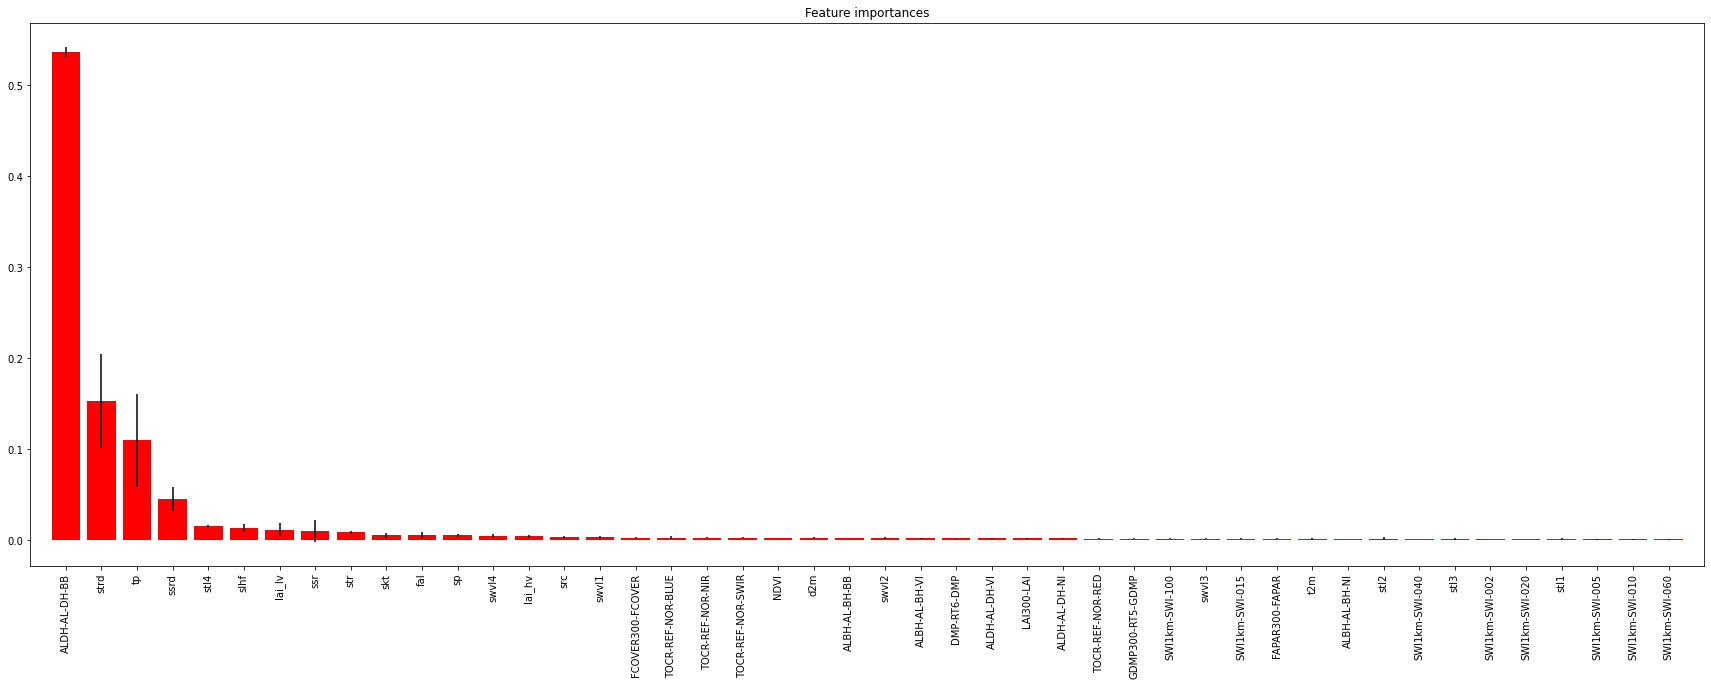

In [212]:
importances = clfXtrain.feature_importances_
std = np.std([tree.feature_importances_ for tree in clfXtrain.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

feat_names = list(df.drop(columns=[regression_label]).columns.values) 

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feat_names[indices[f]], importances[indices[f]]))

names = [feat_names[i] for i in indices]
# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(30, 10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [213]:
imp_index = np.argsort(importances)[::-1]
imp = np.sort(importances)[::-1]

num_feats = 5
print("The first", num_feats, "features contribute to the",  np.cumsum(imp)[num_feats], "of the result")
print("These features are:")
impts = imp_index[:num_feats]
names[:num_feats]
impts

The first 5 features contribute to the 0.8737808232589879 of the result
These features are:


array([ 4, 40, 41, 39, 34])

Regression Tree model score:  0.8930590061858649


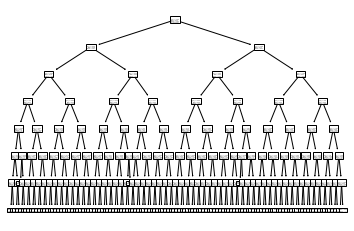

In [216]:
decision_tree = tree.DecisionTreeRegressor(max_depth=7)
decision_tree = decision_tree.fit(X_train[:,impts],y_train)
print("Regression Tree model score: ", decision_tree.score(X_test[:,impts], y_test))

plt.figure()
tree.plot_tree(decision_tree)
plt.show()